In [89]:
#Importing libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

In [90]:
#test --> covid, normal, viral pneumonia
#train --> covid, normal, viral pneumonia
#notes on images:
#Greyscale pictures, 1 color channel, color mode = "greyscale"
#651 x 659 pixels, multi-class classification

In [91]:
#Initialising imagedate generators for the training and validation data. 

# Initialize an ImageDataGenerator for the training data with various augmentations
training_data_generator = ImageDataGenerator(
    rescale=(1.0/255),              # Rescale pixel values from 0-255 to 0-1
    zoom_range=0.2,                 # Randomly zoom in on images
    rotation_range=10,              # Randomly rotate images by up to 10 degrees
    width_shift_range=0.05,         # Randomly shift images horizontally by 5% of the width
    height_shift_range=0.05         # Randomly shift images vertically by 5% of the height
)

# Initialize an ImageDataGenerator for the validation data, only rescaling the pixel values
validation_data_generator = ImageDataGenerator(rescale=1./255)  # Rescale pixel values from 0-255 to 0-1

In [92]:
#creating iterators for both the training and validation data which we will then use to train the model after its compilation
# Create an iterator for the training data
training_iterator = training_data_generator.flow_from_directory(
    "data/train",                   # Directory with training images
    class_mode="categorical",            # Sparse classification mode for integer labels
    color_mode="grayscale",         # Convert images to grayscale
    target_size=(651, 659),         # Resize images to 651x659 pixels
    batch_size=32                   # Process images in batches of 32
)


# Create an iterator for the validation data
validation_iterator = validation_data_generator.flow_from_directory(
    'data/test',                    # Directory with validation images
    class_mode='categorical',            # Sparse classification mode for integer labels
    color_mode='grayscale',         # Convert images to grayscale
    target_size=(651, 659),         # Resize images to 651x659 pixels
    batch_size=32                   # Process images in batches of 32
)

# Print the shape of the validation data iterator for verification (for debugging)
# Fetch a single batch from the validation iterator
batch_images, batch_labels = next(validation_iterator)
tbatch_images, tbatch_labels = next(training_iterator)
# Print the shape of the images and labels
print(f"Batch image shape: {batch_images.shape}")  
print(f"Batch label shape: {batch_labels.shape}")  
print(f"TBatch image shape: {tbatch_images.shape}")  
print(f"TBatch label shape: {tbatch_labels.shape}")  



Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Batch image shape: (32, 651, 659, 1)
Batch label shape: (32, 3)
TBatch image shape: (32, 651, 659, 1)
TBatch label shape: (32, 3)


In [93]:
# Build the CNN model
model = tf.keras.Sequential()  # Initialize a sequential model

# Add layers to the model
model.add(tf.keras.Input(shape=(651, 659, 1)))  # Input layer for 651x659 grayscale images (1 channel)
model.add(tf.keras.layers.Conv2D(4, 3, strides=2, activation="relu"))  # 2D convolutional layer with 4 filters, 3x3 kernel, stride of 2, ReLU activation
model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(3, 3)))  # Max pooling layer with 4x4 pool size, stride of 3

model.add(tf.keras.layers.Conv2D(3, 5, strides=3, activation="relu"))  # 2D convolutional layer with 3 filters, 5x5 kernel, stride of 3, ReLU activation
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))  # Max pooling layer with 3x3 pool size, stride of 2

model.add(tf.keras.layers.Flatten())  # Flatten the output from the convolutional layers into a 1D array
model.add(tf.keras.layers.Dense(12, activation="relu"))  # Dense (fully connected) layer with 12 neurons and ReLU activation
model.add(tf.keras.layers.Dense(3, activation="softmax"))  # Output layer with 3 neurons (one for each class) and softmax activation for multi-class classification

In [94]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Use the Adam optimizer with a learning rate of 0.001
    loss=tf.keras.losses.CategoricalCrossentropy(),      # Use sparse categorical crossentropy as the loss function
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()]  # Track categorical accuracy and AUC during training
)

In [95]:
# Train the model and prepare model visualisation

log_dir = "logs"

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,  # Write model graph
    write_images=True  # Write model weights as images
)


history = model.fit(
    training_iterator,        # Training data iterator
    epochs=12,                # Train for 12 epochs
    validation_data=validation_iterator,
    callbacks=[tensorboard_callback] # Validation data iterator
)

Epoch 1/12
8/8 [==============================] - 11s 1s/step - loss: 1.0913 - categorical_accuracy: 0.5418 - auc_10: 0.6678 - val_loss: 1.0798 - val_categorical_accuracy: 0.6515 - val_auc_10: 0.7885
Epoch 2/12
8/8 [==============================] - 9s 1s/step - loss: 1.0706 - categorical_accuracy: 0.7291 - auc_10: 0.8605 - val_loss: 1.0603 - val_categorical_accuracy: 0.6970 - val_auc_10: 0.8307
Epoch 3/12
8/8 [==============================] - 9s 1s/step - loss: 1.0445 - categorical_accuracy: 0.7888 - auc_10: 0.8799 - val_loss: 1.0339 - val_categorical_accuracy: 0.6667 - val_auc_10: 0.8095
Epoch 4/12
8/8 [==============================] - 9s 1s/step - loss: 1.0179 - categorical_accuracy: 0.7171 - auc_10: 0.8377 - val_loss: 0.9793 - val_categorical_accuracy: 0.7576 - val_auc_10: 0.9142
Epoch 5/12
8/8 [==============================] - 9s 1s/step - loss: 0.9415 - categorical_accuracy: 0.8287 - auc_10: 0.9409 - val_loss: 0.9058 - val_categorical_accuracy: 0.7727 - val_auc_10: 0.9322
Epoc

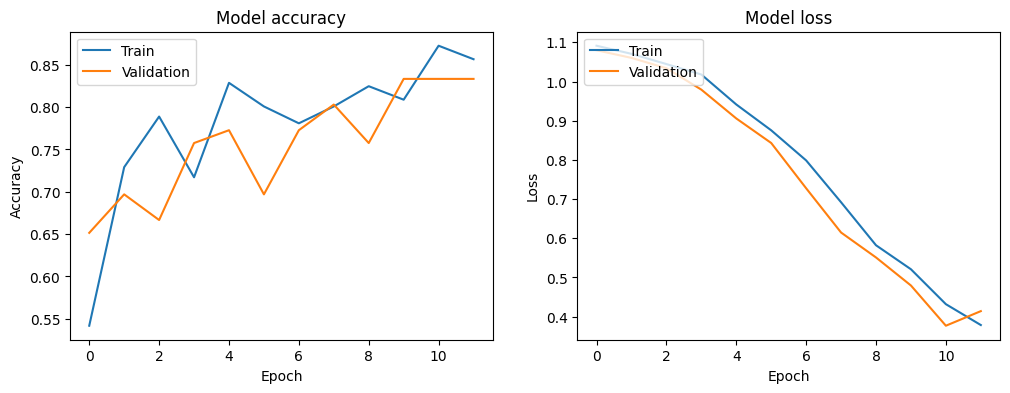

In [96]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [97]:
%load_ext tensorboard
%tensorboard --logdir logs
